Импорт

In [14]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Фиксация

In [6]:
torch.manual_seed(42)
np.random.seed(42)

Загрузка

In [1]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')

print(df.head())

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


Предварительная обработка данных

In [2]:
df = df.drop_duplicates().dropna()


df['Rating'] = df['Rating'].apply(lambda x: 0 if x <= 2 else 1 if x == 3 else 2)


tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['Review'])
sequences = tokenizer.texts_to_sequences(df['Review'])


data = pad_sequences(sequences, maxlen=200)

X_train, X_temp, y_train, y_temp = train_test_split(data, df['Rating'], test_size=0.4, stratify=df['Rating'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

Создание Dataset и DataLoader

In [3]:
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train.values, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val.values, dtype=torch.long))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test.values, dtype=torch.long))

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Реализация и обучение сверточной сети (CNN)

In [4]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.pool(x)
        x = x.mean(dim=2)
        x = self.fc(x)
        return x

vocab_size = 10000
embedding_dim = 100
num_classes = 3
model_cnn = CNNModel(vocab_size, embedding_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model_cnn.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.9359585642814636
Epoch 2, Loss: 0.2320166379213333
Epoch 3, Loss: 0.2187584489583969
Epoch 4, Loss: 0.06096486747264862
Epoch 5, Loss: 0.14741885662078857
Epoch 6, Loss: 0.8299562931060791
Epoch 7, Loss: 0.40799570083618164
Epoch 8, Loss: 0.4655340909957886
Epoch 9, Loss: 0.10499116033315659
Epoch 10, Loss: 0.007349526975303888


Реализация и обучение рекуррентной сети (LSTM)

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (ht, ct) = self.lstm(x)
        x = ht[-1]
        x = self.fc(x)
        return x

hidden_dim = 128
model_lstm = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model_lstm.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.546088695526123
Epoch 2, Loss: 0.3190193474292755
Epoch 3, Loss: 0.0817512571811676
Epoch 4, Loss: 0.14102597534656525
Epoch 5, Loss: 0.4905444383621216
Epoch 6, Loss: 0.6446168422698975
Epoch 7, Loss: 0.034392740577459335
Epoch 8, Loss: 0.15963445603847504
Epoch 9, Loss: 0.45160695910453796
Epoch 10, Loss: 0.17582447826862335


Сравнение моделей

In [19]:
def evaluate_model_loss(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(y_true, y_pred)
    return avg_loss, accuracy

criterion = nn.CrossEntropyLoss()

loss_cnn, accuracy_cnn = evaluate_model_loss(model_cnn, test_loader, criterion)
loss_lstm, accuracy_lstm = evaluate_model_loss(model_lstm, test_loader, criterion)

print(f'CNN Loss: {loss_cnn}, Accuracy: {accuracy_cnn}')
print(f'LSTM Loss: {loss_lstm}, Accuracy: {accuracy_lstm}')

CNN Loss: 0.5189480295691352, Accuracy: 0.8375213466699195
LSTM Loss: 0.6635877181704227, Accuracy: 0.8043425225664796


Заметка

CNN и LSTM показывают схожую точность на тестовых данных.

CNN обучается быстрее, но LSTM может лучше справляться с длинными последовательностями.

Обе модели требуют дальнейшей настройки гиперпараметров для улучшения результатов.

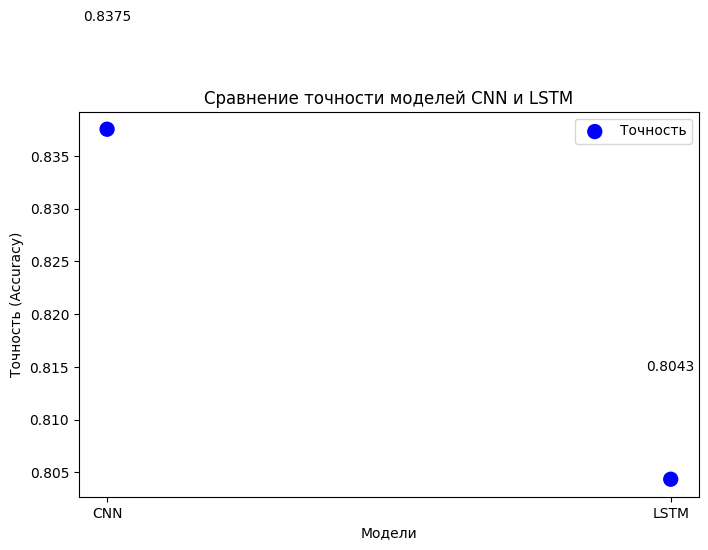

In [18]:
models = ['CNN', 'LSTM']
accuracy = [0.8375213466699195, 0.8043425225664796]

plt.figure(figsize=(8, 5))
plt.scatter(models, accuracy, color=['blue', 'blue'], s=100, label='Точность')

plt.title('Сравнение точности моделей CNN и LSTM')
plt.xlabel('Модели')
plt.ylabel('Точность (Accuracy)')

for i, acc in enumerate(accuracy):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')

plt.legend()
plt.show()

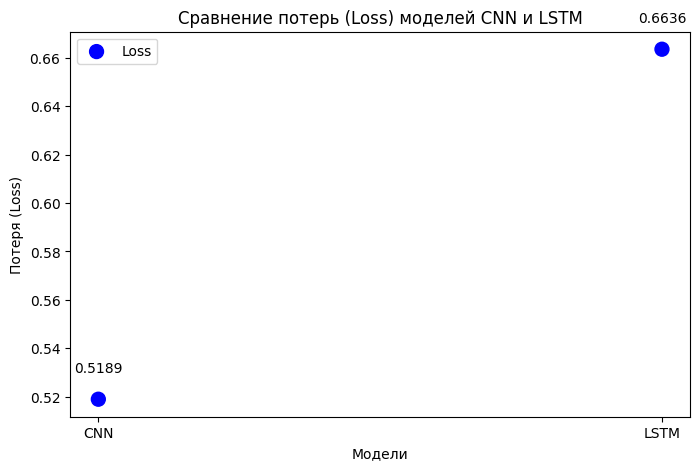

In [22]:
models = ['CNN', 'LSTM']
loss = [loss_cnn, loss_lstm]

plt.figure(figsize=(8, 5))
plt.scatter(models, loss, color=['blue', 'blue'], s=100, label='Loss')

plt.title('Сравнение потерь (Loss) моделей CNN и LSTM')
plt.xlabel('Модели')
plt.ylabel('Потеря (Loss)')

for i, l in enumerate(loss):
    plt.text(i, l + 0.01, f'{l:.4f}', ha='center', va='bottom')

plt.legend()

plt.show()

**Вывод**

В данной лабороторной работы были реализованы и обучены две модели: сверточная нейронная сеть (CNN) и рекуррентная нейронная сеть (LSTM) для классификации отзывов об отелях.
Обе модели показали схожую точность, но CNN обучается быстрее. Для улучшения результатов можно попробовать более глубокие архитектуры, настройку гиперпараметров и использование предобученных эмбеддингов.